When it comes to consuming real-time content, Twitter is the place to be; Be it sending out 'Tweets' real-time, or discovering latest online 'Trends' anywhere in the world, or ability to begin a 'conversation' with anyone, Twitter does it all. In fact, Twitter Management wrote this in their [letter to shareholders][1] last year. 
[1]: http://files.shareholder.com/downloads/AMDA-2F526X/106725176x0x874459/8A4D1A1D-D184-4AFE-9AC1-F880C5EA06F1/Q415_Shareholder_Letter.pdf

> _We’re focused now on what Twitter does best: live. Twitter is live: live commentary, live connections, live conversations. Whether it’s breaking news, entertainment, sports, or everyday topics, hearing about and watching a live event unfold is the fastest way to understand the power of Twitter._ 

> _Twitter has always been considered a “second screen” for what’s happening in the world and we believe we can become the first screen for everything that’s happening now. And by doing so, we believe we can build the planet’s largest daily connected audience. A connected audience is one that watches together, and can talk with one another in real-time. It’s what Twitter has provided for close to 10 years, and it’s what we will continue to drive in the future_

Embedded in a Twitter user's Social-graph* is a wealth of information on user's likes and interests. Unlike Facebook or LinkedIn, the magic of Twitter is its 'Follow' structure - where anybody can follow anyone without the two knowing each other. This directed social-graph when methodologically summarized can reveal interesting information on the most influential/central friends in the network and also help personalize/enrich one's Twitter experience considerably by understanding implicit-clusters in the network.

_*Social-graph: [User, 1st degree Connections, and the links between]_

In this story, we'll look into these: 
1. Extract the ego-network of 'self' using Twitter API 
+ Identify the influential nodes using 'Page Rank' formulation 
+ Identify implicit clusters formed
+ Recommend new friends to follow on the basis of cluster of interest 

Note: This study is limited to  Ego network i.e. 'self' node which is focal node ("ego") and the nodes to whom ego is directly connected to ("alters") plus the ties, if any, among the alters. 

## 1. Extract social-graph strucutre using Twitter API 

In [1]:
from collections import Counter, defaultdict
from datetime import datetime
from sklearn.decomposition import PCA

import csv
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import re
import seaborn as sns;  sns.set()
import time
import twitter

% matplotlib inline
plt.rcParams['figure.figsize'] = (10,7)

import warnings
warnings.filterwarnings("ignore")
#print twitter.__path__  

In [2]:
# Pandas data-frame print formatting
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
self_screen_name = 'bala_io'            # Self

# Keep appending data
fof_filename     = "edges.csv"          # 'Alters' and their Source->Sink Edges. 
cache_filename   = "cache.csv"          # local cache of (TwitterId, FullName, UserName)

# One-time-use files
binaryMap_filename = "binaryMap.csv"   # Directed Graph. Adjacencies as 0/1.RowFollowCol
cluster_filename   = "results.csv"

In [4]:
# Twitter auth. https://dev.twitter.com/oauth/overview/application-owner-access-tokens

with open("../../passwd/credentials.txt", "r") as f:
    reader = csv.reader(f )
    login_dict = {line[0]: line[1]                       
                    for line in reader}        

api = twitter.Api(consumer_key=login_dict.get('consumer_key') ,
                  consumer_secret=login_dict.get('consumer_secret'),
                  access_token_key=login_dict.get('access_token_key'),
                  access_token_secret=login_dict.get('access_token_secret'))
api

In [5]:
# 'Self' and Friends of Self

self_node =  api.GetUser(screen_name = self_screen_name)    
self_node_id = unicode(self_node.id)                        # Twitter Id of Self

friends_of_self = api.GetFriendIDs(user_id = self_node_id, 
                                   screen_name = self_screen_name , 
                                   stringify_ids = True)
index = [self_node_id] + friends_of_self

In [6]:
# GetFriendIDs() API call is rate-limited at 15 req / 15 min 
# https://dev.twitter.com/rest/public/rate-limiting

# For each of the list of nodes, fetch the list of nodes it follows, append to file

def update_FoF_File(fileName, to_fetch_list):
    
    with open(fileName, 'a') as f:
        apiReqCount = 0
        
        for node in to_fetch_list:
            friends_of_node = api.GetFriendIDs(user_id = node,  stringify_ids = True) 
            row = ','.join([str(i) for i in [node] +  friends_of_node ]) + "\n"
            f.write(row) 
            
            apiReqCount += 1
            
            if (apiReqCount == 15): 
                apiReqCount = 0
                
                print("Off to Sleep :)")
                time.sleep(15*60 + 10)  

In [7]:
# parse FoF file and return list of nodes, for whom source->sink Edges are already there.

def getFinishList(fileName):
        
    if not os.path.isfile(fileName):
        return [] 
    with open(fileName, 'r') as f:
        return [ row.strip().split(',')[0] for row in f ]  # 1st entry is a user

In [8]:
# Ego-network as adjacency-matrixa
# Parses FoF file in order of index, create list of adjacencies as 0 | 1
# Writes to File. Adjacency-matrix in Row_follows_Column format

def updateBinaryMapFile(fof_filename, binaryMap_filename, index):
    
    with open(fof_filename, "r") as f:
        stripped_f = (line.replace('\r', '') for line in f)
        reader = csv.reader(stripped_f)
        fof_dict = {line[0]: line[1:] for line in reader 
                    if line[0] in index}   # dict of node:his_followers
        if self_node_id not in fof_dict:
            fof_dict[self_node_id] = index[1:]             # dict of Self
    
    bool_list = []
    
    for user in index:
        user_friends = set( fof_dict[user] )  
        bool_row = [item in user_friends for item in index]  # for each, fill T/F 
        bool_list.append(bool_row)
    
    int_nparray = np.array(bool_list) + 0                    # Bool to int

    binaryMap_rfc = pd.DataFrame(data = int_nparray, columns= index, index = index)
    binaryMap_rfc.to_csv(binaryMap_filename)

In [36]:
# For list of Ids, fetch Profile details. If not in Offline file, make an API call
# Returns ['UserName', 'FullName', 'Followers_count', 'Friends_count', 'Location', 'Created_at']
# UsersLookup API 100 Ids/request

def lookup_in_cache(friendsIdsList):

    cache, delta_cache = pd.DataFrame(), pd.DataFrame()
    UserNameList, namesList     = [], []
    followers_count, friends_count = [], []
    location, created_at           = [], []
    
    if os.path.isfile(cache_filename):
        cache = pd.read_csv(cache_filename, skip_blank_lines=True,
                        dtype={'Ids':str, 'Friends_count':int, 'Followers_count':int})
        cache.set_index('Ids', inplace=True)
        to_fetch_list = list ( set (friendsIdsList) - set(cache.index) )
    else :        
        to_fetch_list = friendsIdsList   
    
    i = 0
    while (i < len(to_fetch_list) * 1./100):     
        print("Cache-Miss for " + str(len(to_fetch_list)) +  " nodes. Querying their Profiles.")
        low, high = i * 100, min( len(to_fetch_list), (i+1)*100 )  # UsersLookup api
        twitterObjectsList = api.UsersLookup(user_id = to_fetch_list[low:high])        
        
        UserNameList += [unicode(tempObject.screen_name) for 
                         tempObject in twitterObjectsList]        
        namesList += [tempObject.name.encode('utf-8').strip() for 
                      tempObject in twitterObjectsList]
        
        followers_count += [unicode(tempObject.followers_count) 
                            for tempObject in twitterObjectsList]        
        friends_count += [unicode(tempObject.friends_count) for 
                          tempObject in twitterObjectsList]        
        
        location += [tempObject.location.encode('utf-8').strip() for 
                     tempObject in twitterObjectsList]
        created_at += [tempObject.created_at.encode('utf-8').strip() for 
                       tempObject in twitterObjectsList]        
        
        i = i + 1       
    
    if len(to_fetch_list) > 0:    
        delta_cache['UserName'], delta_cache['FullName'], delta_cache['Ids'] = UserNameList, namesList, to_fetch_list
        delta_cache['Followers_count'], delta_cache['Friends_count']  = followers_count, friends_count
        delta_cache['Location'], delta_cache['Created_at']  = location, created_at
        
        delta_cache['Created_at'] = delta_cache['Created_at'].apply(lambda x: 
                                                datetime.strptime(
                                                    re.sub(r"\+[0-9]* ", "",x),'%c').
                                                strftime("%b-%Y"))
    
        delta_cache.set_index('Ids', inplace=True, drop = True)
        cache = cache.append(delta_cache)
        cache.to_csv(cache_filename)    
    
    return cache.loc[friendsIdsList]

In [10]:
# Display cluster-wise most-influential users, for the given clustering algo
def top_nodes_in_cluster(df, cluster_algo, n_clusters):
    dummy_df = pd.DataFrame()

    for i in range(n_clusters):
        nodes_in_cluster = list( df [df[cluster_algo] == i ]['FullName'] )     
        if len(nodes_in_cluster) >= 10:            # show only bigger clusters. say size > 10        
            col_name           = str(i) + " : " + str(len(nodes_in_cluster)) + " Ids"
            dummy_df[col_name] = nodes_in_cluster[:10]      
    
    return dummy_df   

In [11]:
# identify 20 friends to follow after aggregating friends followed by top 50% in list

def discover_Friends_toFollow(ids_of_interest, friend_list, prop = .5, count = 20):    
    
    ids_of_interest  = ids_of_interest[:int(len(ids_of_interest) * prop)]
    
    if self_node_id in ids_of_interest:
        ids_of_interest.remove(self_node_id)

    print "'Who-To-Follow' reco after looking at %3d friends' friends:" %(len(ids_of_interest))
    
    with open(fof_filename) as f:
        reader = csv.reader(f)
        fof_dict = {row[0]:row[0:] for row in reader}  # dict of node:her_followers

    friendsToFollow = []
    for id in ids_of_interest:
        friendsToFollow += list (set(fof_dict[str(id)])  - set(friend_list) ) 
        

    friendsToFollow = Counter(friendsToFollow).most_common(count)    
    tuples_list = zip(*friendsToFollow) 
           
    topFriendsToFollowDF = pd.DataFrame()
    topFriendsToFollowDF['Ids'] = list(tuples_list[0])
    topFriendsToFollowDF['Freq'] = list(tuples_list[1])
    topFriendsToFollowDF.set_index('Ids', drop = True, inplace = True)              
    index = topFriendsToFollowDF.index
    
    topFriendsToFollowDF[['UserName', 'FullName', 'Followers_count',
           'Friends_count', 'Location', 'Created_at' ]] = lookup_in_cache(index)#.loc[index]    
    
    return topFriendsToFollowDF    

In [ ]:
# For the list of nodes I follow, fetch their friends-list

fof_finish_list   = getFinishList(fof_filename )        # Completed nodes
fof_to_fetch_list = list ( set(friends_of_self) - set(fof_finish_list) )  # Pending nodes

print( str(len(fof_to_fetch_list)) + " out of " + str(len(index)  - 1) + 
      " Friends details to be fetched")

In [13]:
# For the remaining nodes, populate their details in fof_file
update_FoF_File(fof_filename, fof_to_fetch_list) 

# Build the adjacency matrix in terms of 0 and 1 (if there is an edge)
updateBinaryMapFile(fof_filename, binaryMap_filename, index)

In [14]:
# Read adj-matrix into a data-frame. Cell MxN is 1 iff node in Mth row follows node in Nth column 
binaryMap_rfc = pd.read_csv(binaryMap_filename, skip_blank_lines=True, index_col = 0)
print binaryMap_rfc.shape


outlinks_count = binaryMap_rfc.sum(axis = 1)   # horizontal-sum to count outlinks
inlinks_count = binaryMap_rfc.sum(axis = 0)   # vertical-sum to count inlinks

(376, 376)


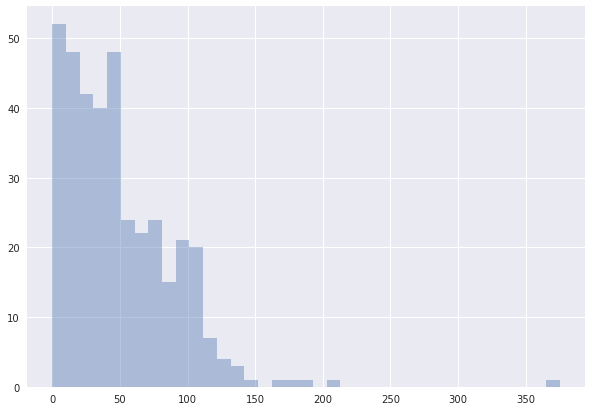

In [15]:
# Histogram of number of OutLinks per node, within ego-network
sns.distplot(outlinks_count, bins = len(index)/10, kde=False);

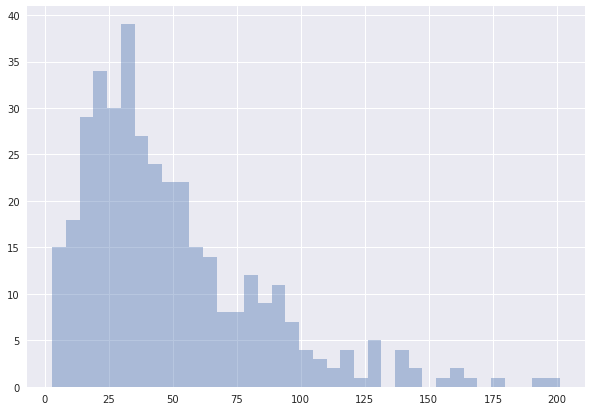

In [16]:
# Histogram of number of InLinks per node, within ego-network
sns.distplot(inlinks_count, bins = len(index)/10, kde=False);

## 2. Identify influential friends using 'Page Rank' formulation

From the adjacency matrix generated above, we can construct a column-stochastic matrix  (also called a transition matrix) such that, a column with `m` outlinks will have `1/m` as value in respective `m` cells. Conceptually, a value in the cell `a x b` gives the probability of a random-surfer in node B jumping to node A. 

In [17]:
binaryMap_cfr      = binaryMap_rfc.transpose()            # column-values: Outlinks
binaryMap_cfr_norm = binaryMap_cfr / binaryMap_cfr.sum(axis = 0)
colStochMatrix = np.matrix( binaryMap_cfr_norm.fillna(0)) # column-stochastic-matrix

_Initialize PageRank vector, such that all the nodes have equal PageRank score adding upto 1._

In [18]:
pageRankVector = np.matrix([1.0/len(index)] *  len(index)) # iniitialize page-rank-vector 
pageRankVector = pageRankVector.transpose()                # transpose to column-vector

On applying the above Transition-matrix transformation iteratively on the PageRank vector, the vector will eventully converge such that:

`Matrix.Vector = Vector`

Equivalently, this is Eigen-Vector formulation i.e. the vector of interest is principal eigen-vector of the matrix corresponding to eigen-value `1`.

Here we use Power Iteration method to solve for the PageRank vector. Inorder to handle  the nodes which have zero out-links (dead-ends) and and nodes with periodic-loops (spider-traps) in the ego-network, we introduce some randomness through parameter `beta` such that a random-surfer at any node picks a random path approx. every 1 out of 6 times ( 1 - beta = 0.15)

In [19]:
# PageRank algo: Power Iteration to solve Markov transition matrix 
# refer this     : http://setosa.io/blog/2014/07/26/markov-chains/index.html

beta = 0.85
epsilon = 999
iteration = 0
while epsilon > (1.0/(10**16)):
    pageRankVectorUpdating = colStochMatrix * pageRankVector * beta 
    
    # re-insert leaked page-ranks
    S = np.array(pageRankVectorUpdating).sum()                      
    pageRankVectorUpdated = pageRankVectorUpdating + (
        1 - S) * (1.0/len(index)) * np.ones_like(len(index))
    
    # compute the squared-difference and check for convergence
    error = np.array(pageRankVectorUpdated - pageRankVector)
    epsilon = np.sqrt((error *  error).sum())   
    iteration = iteration + 1
    pageRankVector = pageRankVectorUpdated    
    
print( "Sum of Page-Rank Scores: " + str(pageRankVector.sum()) + 
      "\nConverged in " + str(iteration) + " iterations")

Sum of Page-Rank Scores: 1.0
Converged in 58 iterations


In [20]:
# Collect the results

results_df = pd.DataFrame()
results_df['Ids'], results_df['PageRank'] = index, pageRankVector
results_df['Inlinks'], results_df['Outlinks'] = list(inlinks_count), list(outlinks_count)
results_df = results_df.set_index('Ids', drop = True )

results_df[['UserName', 'FullName', 'Followers_count',
           'Friends_count', 'Location', 'Created_at' ]] = lookup_in_cache(index)

In [21]:
results_df.fillna('').sort_values(by = 'PageRank', ascending =False).set_index('FullName').head()

,PageRank,Inlinks,Outlinks,UserName,Followers_count,Friends_count,Location,Created_at
FullName,,,,,,,,
Elon Musk,0.014191,201,4,elonmusk,8845530,41,Boring,Jun-2009
Bill Gates,0.011948,168,16,BillGates,34940895,183,"Seattle, WA",Jun-2009
Marc Andreessen,0.011749,192,24,pmarca,645085,13952,"Menlo Park, CA",May-2007
Edward Snowden,0.010110,96,0,Snowden,3150406,1,,Dec-2014
Tim O'Reilly,0.009996,178,132,timoreilly,1987340,1709,"Oakland, CA",Mar-2007


Top 100 influential-nodes in Ego-Network

In [22]:
dummy_df = pd.DataFrame()
temp_df  = results_df.sort_values( by = 'PageRank', ascending =False)

for i in range(10):
    dummy_df[i] = list (temp_df [10*i : 10* i + 10]['FullName'])
dummy_df

,0,1,2,3,4,5,6,7,8,9
0,Elon Musk,Reid Hoffman,Sam Altman,Tim Urban,Microsoft Research,Brian Chesky,Tony Fadell,Naval Ravikant,David Sacks,Clayton Christensen
1,Bill Gates,Bill Gurley,Steven Levy,Joi Ito,John Markoff,Max Roser,Matt Cutts,John D. Cook,Recode,GV
2,Marc Andreessen,Eric Schmidt,Chris Anderson,Benedict Evans,Neil deGrasse Tyson,Bradley Horowitz,Yann LeCun,Tim Ferriss,Tim Berners-Lee,Mark Suster
3,Edward Snowden,Paul Graham,Hilary Mason,Brad Stone,Charlie Rose Show,🍪Steven Sinofsky ॐ,Atul Gawande,John Lilly,Sarah Lacy,Drew Conway
4,Tim O'Reilly,Vinod Khosla,Steve Case,NassimNicholasTaleb,Bill Gross,Gabe Rivera,Jessica Lessin,Dan Primack,Edward Tufte,Fei-Fei Li
5,WIRED,Om Malik,OpenAI,Josh Kopelman,Pierre Omidyar,Walt Mossberg,Google Research,Paul Kedrosky,Sebastian Thrun,Mike Bloomberg
6,Nate Silver,TechCrunch,Sundar Pichai,DAVE MORIN,danah boyd,Steven Pinker,Jonah Peretti,Jimmy Wales,Josh Elman,a16z
7,Chris Dixon,Ben Horowitz,Patrick Collison,Hunter Walk,Emily Chang,Keith Rabois,jason,Startup L. Jackson,Bret Taylor,Kevin Weil
8,Fred Wilson,Kara Swisher,Max Levchin,Y Combinator,dj patil,Glenn Greenwald,EFF,Kevin Kelly,Jeff Hammerbacher,Mike Bostock
9,Ev Williams,Chris Sacca,Nick Bilton,Lessig,Ben Thompson,Andrew Ng,Chamath Palihapitiya,John Collison,Paul Buchheit,Jeff Jordan


Histogram of PageRank scores. PageRank scores are scaled such that nodes have an average-score of 1. So the scores below give an idea of how influential are the nodes, with respect to an average node. 

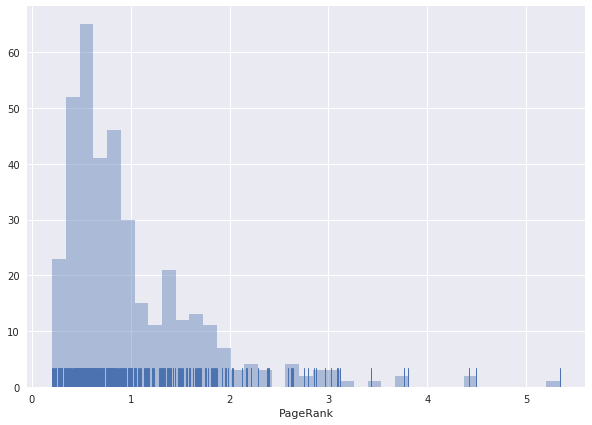

In [23]:
pageRank_to_plot = len(index) * results_df["PageRank"]
sns.distplot(pageRank_to_plot, kde=False, rug=True, bins = len(index)/10);

A joint-plot showing how Inlinks and Outlinks of the nodes are distributed (within the ego-network)

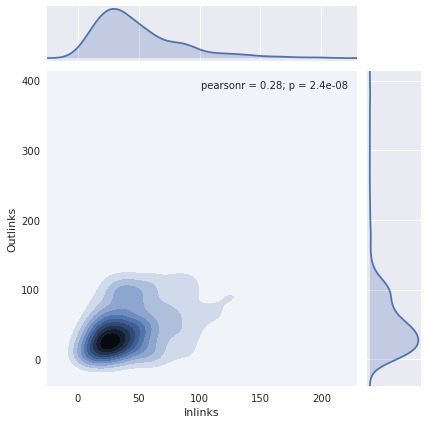

In [24]:
sns.jointplot(x="Inlinks", y="Outlinks", data=results_df, kind = "kde");

## 3. Identify implicit clusters using Clustering algos

Typically, number of clusters are chosen with a plot of within-cluster sum-of-squares-of-dstances vs number of clusters. 
Here for simplicity, we use a simple heuristic to fix the number of clusters in advnace.

In [25]:
n_clusters = min( int( round(np.sqrt(len(index)/2)) ), 10 ) # not more than 10 clusters
print n_clusters

10


## 3a. K-Means clustering

K Means is a point-assignment based clustering-algorithm: here we start with k points chosen randomly as centroids,  assign the remaining points to k centroids by using certain distance measure (Euclidean / Cosine / Jaccardi). Then we compute new centroids, re-assign remaining points and repeat, until there is convergence of centroids. 

Here we are more interested in clustering inherent in who-follows-me (network-driven) graph, rather than who-do-I-follow (self-driven). So the approach is to represent the nodes as Observations and whether other nodes follow them or not (1 or 0) as Features (One observation per row, and one feature per column) Thus the input matrix must be such that any value in cell implies whether node in the column follows node in the row.

In [26]:
from sklearn.cluster import KMeans
est = KMeans(max_iter = 100000, n_clusters = n_clusters, n_init = 250, init='k-means++')  
results_df['kmeans'] = est.fit_predict(binaryMap_cfr)

top_nodes_in_cluster(results_df.sort_values( by = 'PageRank', ascending =False), 
                     'kmeans', n_clusters)

,0 : 12 Ids,1 : 26 Ids,2 : 38 Ids,3 : 18 Ids,4 : 36 Ids,5 : 126 Ids,6 : 28 Ids,7 : 20 Ids,8 : 17 Ids,9 : 55 Ids
0,WIRED,Edward Snowden,Steven Levy,Elon Musk,Tim Ferriss,Tim Urban,Hilary Mason,OpenAI,Microsoft Research,John D. Cook
1,Nate Silver,NassimNicholasTaleb,Sundar Pichai,Bill Gates,John Collison,Charlie Rose Show,dj patil,Andrew Ng,Mike Bostock,Gilad Lotan
2,TechCrunch,Neil deGrasse Tyson,Patrick Collison,Marc Andreessen,Paul Buchheit,WikiLeaks,Jeff Hammerbacher,Yann LeCun,Steven Brooks,Lynn Cherny
3,Chris Anderson,danah boyd,Nick Bilton,Tim O'Reilly,GV,Irene Au,Drew Conway,Google Research,Jeffrey Heer,Andrew Gelman
4,Steve Case,Max Roser,Benedict Evans,Chris Dixon,Jeff Jordan,Seth Godin,Wes McKinney,Sebastian Thrun,Martin Wattenberg,David Smith
5,Joi Ito,Steven Pinker,Brad Stone,Fred Wilson,Garry Tan,Tom Hulme,Monica Rogati,Fei-Fei Li,Fernanda Viégas,Kenneth Cukier
6,Lessig,Glenn Greenwald,Josh Kopelman,Ev Williams,Joe Gebbia,Udacity,Hadley Wickham,Andrej Karpathy,Tim Harford,Fernando Perez
7,John Markoff,Atul Gawande,DAVE MORIN,Reid Hoffman,Bryce Roberts,briankrebs,Sean J. Taylor,Shivon Zilis,Steven Strogatz,Andreas Mueller
8,Bill Gross,EFF,Hunter Walk,Bill Gurley,Yves Behar,Christopher Soghoian,Nathan Yau,Pedro Domingos,Duncan Watts,Kaggle
9,Pierre Omidyar,Jimmy Wales,Y Combinator,Eric Schmidt,Dustin Moskovitz,IDEO,Peter Skomoroch,Stanford NLP Group,Jure Leskovec,John Foreman


## 3b. Spectral clustering

One problem in using K-Means algorithm to cluster the given social-graph is 'Curse of Dimensionality' i.e. at higher-dimensions (here ~400 dimensions), metric like 'Euclidean distance' or 'Centre' would have little meaning in the context of non-convex adjacency matrix.

On the other hand, spectral clustering attempts to partition the graph such that number of edges which connect different components are minimized. Below is the output from Spectral Clustering.

In [27]:
from sklearn import cluster

spectral = cluster.SpectralClustering(n_clusters=n_clusters,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
spectral.fit(binaryMap_cfr)
results_df['spectral'] = spectral.labels_.astype(np.int)

top_nodes_in_cluster(results_df.sort_values( by = 'PageRank', ascending =False), 
                     'spectral', n_clusters)

,0 : 14 Ids,1 : 187 Ids,3 : 16 Ids,4 : 28 Ids,6 : 12 Ids,7 : 36 Ids,8 : 57 Ids,9 : 11 Ids
0,Andrew Ng,Edward Snowden,Olivier Grisel,Ev Williams,Luke Wroblewski,dj patil,Nate Silver,Elon Musk
1,Yann LeCun,Tim O'Reilly,Fernando Perez,Bill Gurley,Matías Duarte,Jeff Hammerbacher,Sundar Pichai,Bill Gates
2,Fei-Fei Li,WIRED,Andreas Mueller,Om Malik,Julie Zhuo,Monica Rogati,Patrick Collison,Marc Andreessen
3,Andrej Karpathy,Eric Schmidt,Jake VanderPlas,Kara Swisher,Jon Wiley,Peter Skomoroch,Y Combinator,Chris Dixon
4,Stanford NLP Group,Vinod Khosla,Scientific Python,Steven Levy,Daniel Burka,Michael E. Driscoll,Emily Chang,Fred Wilson
5,Richard,TechCrunch,Sebastian Raschka,Nick Bilton,Braden Kowitz,Jeremy Howard,Ben Thompson,Reid Hoffman
6,John Platt,Chris Anderson,Trey Causey,Benedict Evans,Google Design,bradford cross,Brian Chesky,Paul Graham
7,Oren Etzioni,Steve Case,Joshua Bloom,Josh Kopelman,Josh Brewer,Mike Olson,🍪Steven Sinofsky ॐ,Ben Horowitz
8,Ian Goodfellow,OpenAI,Peter Wang,DAVE MORIN,Jake Knapp,Anthony Goldbloom,Tony Fadell,Chris Sacca
9,Nando de Freitas,Tim Urban,Thomas Wiecki,Hunter Walk,John Zeratsky,Joe Hellerstein,Tim Ferriss,Sam Altman


Nodes mainly into Deep Learning community have grouped into Cluster 0, Python Machine Learning community into Cluster 3, Design community into Cluster 6, general Data Science community into Cluster 7

Two other smaller clusters (2 and 5) weren't shown above.
Interestingly Cluster 5 is also that of Data-Science community.

In [31]:
results_df [results_df['spectral'].isin([5])].sort_values(by = 'PageRank', ascending =False).set_index('FullName')

,PageRank,Inlinks,Outlinks,UserName,Followers_count,Friends_count,Location,Created_at,kmeans,spectral
FullName,,,,,,,,,,
Hilary Mason,0.005899,127,94,hmason,91275,1417,NYC,Feb-2007,6,5
Drew Conway,0.003475,75,55,drewconway,19662,298,"Brooklyn, NY",Dec-2008,6,5
Wes McKinney,0.003158,73,73,wesmckinn,21537,687,"New York, NY",Feb-2010,6,5
Hadley Wickham,0.003049,68,36,hadleywickham,44530,304,"Houston, TX",Aug-2009,6,5
Sean J. Taylor,0.002931,72,132,seanjtaylor,13728,2090,"San Francisco, CA",Feb-2009,6,5
Nathan Yau,0.002858,66,18,flowingdata,63514,193,California,Mar-2008,6,5
John Myles White,0.002426,64,9,johnmyleswhite,19367,31,"New York, NY",Jul-2008,6,5
Ben Lorica 罗瑞卡,0.002011,55,34,bigdata,38187,265,"San Francisco, CA",Dec-2008,6,5


## 3c. Affinity Propagation clustering

Unlike K-Means or Spectral clustering, affinity propagation doesn't require the number of clusters to be estimated beforehand. Here the algorithm finds 'exemplars' i.e. members of dataset that are representative of clusters. and tries to find clusters around them.  

In [32]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(preference=-50).fit(binaryMap_cfr)
results_df['affinity'] = af.labels_
n_clusters_affinity = len(af.cluster_centers_indices_)

print str(n_clusters_affinity) + " affinity clusters."

top_nodes_in_cluster(results_df.sort_values( by = 'PageRank', ascending =False), 
                     'affinity', n_clusters_affinity)

125 affinity clusters.


,2 : 119 Ids,30 : 20 Ids,36 : 14 Ids,39 : 12 Ids,108 : 45 Ids
0,Charlie Rose Show,Lynn Cherny,John D. Cook,Jeff Jordan,Tim Urban
1,EFF,Ben Hamner,chris wiggins,Dustin Moskovitz,Yves Behar
2,Irene Au,Olivier Grisel,Jeremy Howard,Balaji S. Srinivasan,Ashlee Vance
3,Paul Ford,Fernando Perez,Xavier Amatriain,Horace Dediu,WikiLeaks
4,briankrebs,Andreas Mueller,Anthony Goldbloom,Jessica Livingston,John Carmack
5,Christopher Soghoian,Jake VanderPlas,Kaggle,David Marcus,Seth Godin
6,IDEO,Scientific Python,John Foreman,Frank Chen,The Information
7,John Hagel,Sebastian Raschka,Edwin Chen,Kleiner Perkins,Tom Hulme
8,Tim Harford,Trey Causey,ericcolson,Amir Efrati,Udacity
9,Steven Strogatz,Joshua Bloom,DataKind,Sarah Frier,Scott Dadich


## 3d. Principal Component Analysis

To handle the 'curse of dimensionality' problem inherent in high-dimension data, PCA is generally used to represent the high-dimensional data in a fewer number of dimensions - this helps in better visualizing of data as well as faster computation while running clustering algorithm.

In [33]:
pca = PCA(n_components=2)
Xproj = pca.fit_transform(binaryMap_cfr)

results_df['dim1'] = Xproj[:,0]
results_df['dim2'] = Xproj[:,1]

results_df = results_df.sort_values( by = 'PageRank', ascending =False)
results_df.to_csv(cluster_filename)

print "Explained-variance and Proportion of Explained-variance in 2 dimensions [dim1  dim2]"
print pca.explained_variance_, pca.explained_variance_ratio_

Explained-variance and Proportion of Explained-variance in 2 dimensions [dim1  dim2]
[ 7.0893063   3.15651646] [ 0.18391509  0.08188827]


A simpler visualization of Spectral-clustering outcome as rendered in 2 dimensions.

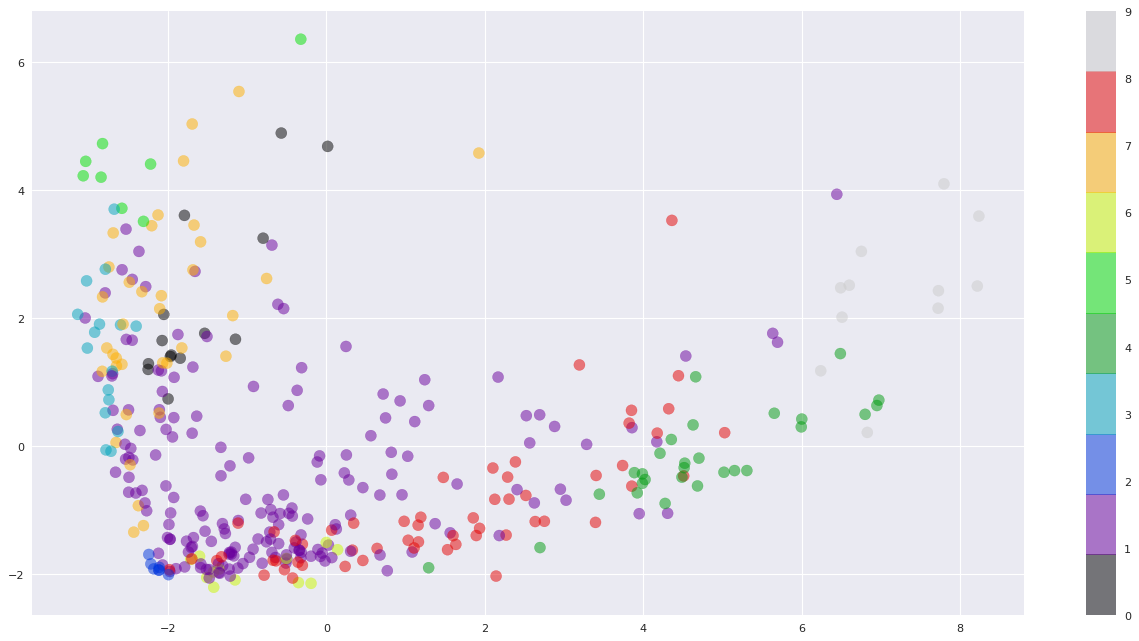

In [34]:
# Spectral clustering | Plot the ego-network in 2 dimensions

plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(results_df['dim1'], results_df['dim2'], s = 100  ,c= results_df['spectral'], 
            alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar();

More on Clustering Algorithms:  http://scikit-learn.org/stable/modules/clustering.html

## 4. Recommend new friends to follow

Now that we have PageRank in place for nodes in social-graph, we can ask for recommendations on the basis of top-ranked nodes in the graph. E.g. To get 20 recommendations, after looking at friends of top PageRank scored nodes in my network

In [35]:
discover_Friends_toFollow(ids_of_interest = results_df.index, 
                          friend_list = index, 
                          prop = .5 , count =  20).fillna('').set_index('FullName')

'Who-To-Follow' recommendations after looking at 188 friends' friends:


,Freq,UserName,Followers_count,Friends_count,Location,Created_at
FullName,,,,,,
jack,95,jack,4055017,2791,"California, USA",Mar-2006
Barack Obama,95,BarackObama,88892730,629775,"Washington, DC",Mar-2007
Aaron Levie,92,levie,1626688,423,Palo Alto,Mar-2007
John Doerr,81,johndoerr,287661,372,,Feb-2009
marissamayer,79,marissamayer,1705305,350,"San Francisco, CA",Nov-2008
dick costolo,78,dickc,1739649,681,San Francisco,May-2007
Drew Houston,75,drewhouston,248475,382,"San Francisco, CA",Mar-2008
Mitch Kapor,73,mkapor,116400,553,Oakland,Mar-2007
Medium,72,Medium,2188119,78,"San Francisco, CA, US",May-2012


Recommendations on the basis of a specific cluster outcome. 
E.g. Nodes to follow on the basis of top PageRank nodes in the list of 'Spectral Clustering::Data' clusters. 

In [37]:
favorite_cluster_df = results_df [results_df['spectral'].isin([0,3,7,5])]
favorite_cluster_list = list(favorite_cluster_df.index)

discover_Friends_toFollow(ids_of_interest = favorite_cluster_list, 
                          friend_list = index, 
                          prop = .5, count = 30).fillna('').set_index('FullName')  

'Who-To-Follow' recommendations after looking at  37 friends' friends:
Cache-Miss for 3 nodes. Querying their Profiles.


,Freq,UserName,Followers_count,Friends_count,Location,Created_at
FullName,,,,,,
Pete Warden,21,petewarden,12142,1559,"San Francisco, CA",May-2008
Hanna Wallach,17,hannawallach,7537,795,"Brooklyn, NY",Sep-2012
Alex Smola,17,smolix,8768,48,Mountain View and Pittsburgh,Jun-2008
Barack Obama,17,BarackObama,88892730,629775,"Washington, DC",Mar-2007
Oriol Vinyals,16,OriolVinyalsML,18911,42,"London, England",Oct-2015
Hal Daumé III,16,haldaume3,8702,1017,Washington DC,Jun-2010
Julie Steele,16,jsteeleeditor,4199,913,NYC and Providence,Mar-2008
Jack Clark,16,jackclarkSF,18015,2506,"San Francisco, CA",Oct-2009
Hugo Larochelle,15,hugo_larochelle,22563,350,,Jun-2015
